In [38]:
import pandas as pd
import pymongo
from datetime import datetime
import math
import numpy as np
from numba import jit
import geojson


In [39]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")

mydb = myclient["tu-around"]
mycol = mydb["gpslogs"]

In [40]:
myquery = { "carno": "0TU0001 (1B)",
           "acctime": { "$gte": datetime(2019,11,19, 3, 43, 0),
                       "$lt": datetime(2019, 11, 19, 4, 10, 0)} }
myselector = { "_id": 0, "lat": 1, "lon": 1, "timestamp": 1,
              "acctime": 1, "speed": 1, "direction": 1
             }
mydoc = mycol.find(myquery, myselector)
gps_log =  pd.DataFrame(list(mydoc))
# remove 0 speed
gps_log = gps_log[gps_log['speed'] > 0]

In [41]:
df = pd.read_csv('shapes.txt')
ngv1b = df[df['shape_id'] == 'ngv1b_0']

In [7]:
import matplotlib.pyplot as plt

BBox = ((df.shape_pt_lon.min(),   df.shape_pt_lon.max(),      
         df.shape_pt_lat.min(), df.shape_pt_lat.max())
       )
        
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(ngv1b.shape_pt_lon, ngv1b.shape_pt_lat, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on TU-NGV Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])


(14.0657426, 14.077905553749266)

In [8]:
import numpy as np

def interpcurve(N,pX,pY):
    #equally spaced in arclength
    N=np.transpose(np.linspace(0,1,N))

    #how many points will be uniformly interpolated?
    nt=N.size

    #number of points on the curve
    n=pX.size
    pxy=np.array((pX,pY)).T
    p1=pxy[0,:]
    pend=pxy[-1,:]
    last_segment= np.linalg.norm(np.subtract(p1,pend))
    epsilon= 10*np.finfo(float).eps

    #IF the two end points are not close enough lets close the curve
    if last_segment > epsilon*np.linalg.norm(np.amax(abs(pxy),axis=0)):
        pxy=np.vstack((pxy,p1))
        nt = nt + 1
    else:
        print('Contour already closed')

    pt=np.zeros((nt,2))

    #Compute the chordal arclength of each segment.
#     chordlen = (np.sum(np.diff(pxy,axis=0)**2,axis=1))**(1/2)
    chordlen = haversine_np_array(pxy)
    #Normalize the arclengths to a unit total
    chordlen = chordlen/np.sum(chordlen)
    #cumulative arclength
    cumarc = np.append(0,np.cumsum(chordlen))

    tbins= np.digitize(N,cumarc) # bin index in which each N is in

    #catch any problems at the ends
    tbins[np.where(tbins<=0 | (N<=0))]=1
    tbins[np.where(tbins >= n | (N >= 1))] = n - 1      

    s = np.divide((N - cumarc[tbins]),chordlen[tbins-1])
    pt = pxy[tbins,:] + np.multiply((pxy[tbins,:] - pxy[tbins-1,:]),(np.vstack([s]*2)).T)

    return pt 

In [9]:
pt = interpcurve(1064, ngv1b.shape_pt_lon, ngv1b.shape_pt_lat )
start_pt = pt[0]
dist_arr = []
bearing_arr = []
speed = np.full((pt.shape[0]), 4.4 )

for i in range(0, pt.shape[0]):
    next_pt = pt[i]
    dist = haversine_np(start_pt[0], start_pt[1], next_pt[0], next_pt[1])
    dist_arr.append(dist)
    b = bearing(start_pt[0], start_pt[1], next_pt[0], next_pt[1])
    bearing_arr.append(b)
    start_pt = next_pt
route_info = pd.DataFrame({
    'lon': pt.T[0],
    'lat': pt.T[1],
    'dist': dist_arr,
    'bearing': bearing_arr,
    'speed': speed,
})
route_info["time_to_next"] = route_info.dist / route_info.speed

In [10]:
# stop located
stop_time_df = pd.read_csv('stop_times.txt')
stops_df = pd.read_csv('stops.txt')
ngv1b_stops_df = stop_time_df[stop_time_df['trip_id'] == 'NGV-1b001']
lat_arr = []
lon_arr = []
for index, row in ngv1b_stops_df.iterrows():
    cur_row = stops_df.loc[stops_df['stop_id'] == row['stop_id']]
    lat_arr.append(cur_row.stop_lat.values[0])
    lon_arr.append(cur_row.stop_lon.values[0])
ngv1b_stops = pd.DataFrame({
    'stop_id': ngv1b_stops_df['stop_id'],
    'stop_lat': lat_arr,
    'stop_lon': lon_arr
})
# df.loc[df['column_name'] == some_value]

In [11]:
# stop route matching
stops_loc_arr = []
cur_index = 1
for stop_index, stop_row in ngv1b_stops.iterrows():
    shortest_index = -1
    shortest_dist = 999999
    for index, row in route_info.iloc[cur_index:].iterrows():
        dist = haversine_np(stop_row.stop_lon, stop_row.stop_lat, row.lon, row.lat)
#       closest road might be far on index
        dist += (index - cur_index) * 1
        if shortest_dist > dist:
            shortest_dist = dist
            shortest_index = index
    cur_index = shortest_index
    stops_loc_arr.append(cur_index)
ngv1b_stops['stop_index'] = stops_loc_arr

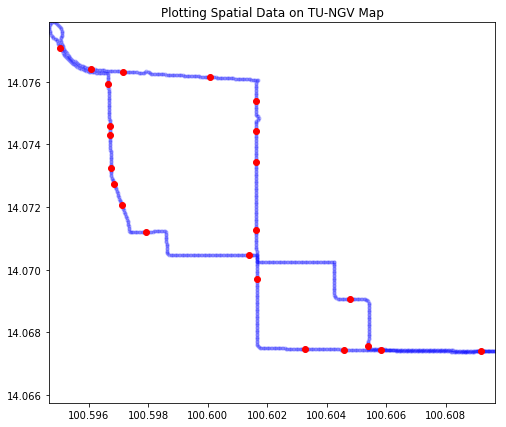

In [12]:
import matplotlib.pyplot as plt

BBox = ((df.shape_pt_lon.min(),   df.shape_pt_lon.max(),      
         df.shape_pt_lat.min(), df.shape_pt_lat.max())
       )
        
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(route_info['lon'], route_info['lat'], zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on TU-NGV Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
# plot stop
for stop_index, stop_row in ngv1b_stops.iterrows():
    route_info_row = route_info.loc[stop_row['stop_index']]
    plt.plot(route_info_row['lon'], route_info_row['lat'], 'ro')

In [13]:
route_info.count()

lon             1064
lat             1064
dist            1064
bearing         1064
speed           1064
time_to_next    1064
dtype: int64

(14.0657426, 14.077905553749266)

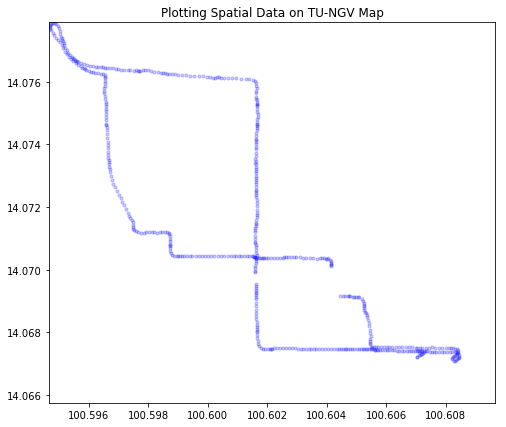

In [14]:
import matplotlib.pyplot as plt

BBox = ((df.shape_pt_lon.min(),   df.shape_pt_lon.max(),      
         df.shape_pt_lat.min(), df.shape_pt_lat.max())
       )
        
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(gps_log.lon, gps_log.lat, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on TU-NGV Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

In [15]:
# %%timeit
# stop route matching for gps_log

matched_arr = []
cur_index = 1
# cur_index = 1
def match_route(x):
    global cur_index
    ri = route_info[cur_index:]
    bearing_dist = abs(x.direction - ri.bearing ) / 10
    # bearing_dist.apply(lambda x: 36 - x if x > 18 else x)
    dist = haversine_np(ri.lon.values, ri.lat.values, x.lon, x.lat)
    dist += bearing_dist
    dist += ri.index.values - cur_index
    cur_index = dist.idxmin()
    return dist.idxmin()
gps_log['matched']  =  gps_log.apply(match_route, axis=1)

In [16]:
# stop closest position index
ngv_stop_index = []
for stop_index, stop_row in ngv1b_stops.iterrows():
    closest_index = -1
    closet_dist = 999999
    for index, value in gps_log.iterrows():
        dist = abs(stop_row['stop_index'] - value['matched'])
        if dist < closet_dist:
            closet_dist = dist
            closest_index = index
        if dist == 0:
            break
    ngv_stop_index.append(closest_index)
ngv1b_stops['real'] = ngv_stop_index 

(14.0657426, 14.077905553749266)

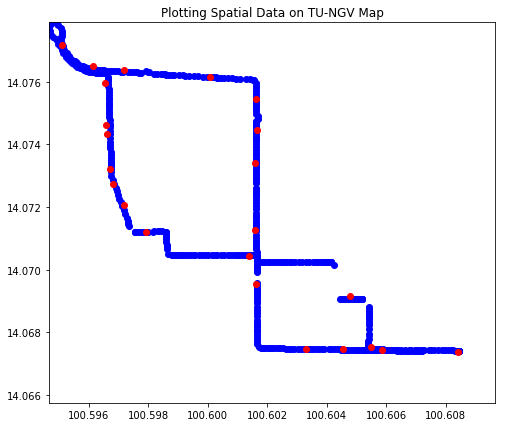

In [17]:
import matplotlib.pyplot as plt

BBox = ((df.shape_pt_lon.min(),   df.shape_pt_lon.max(),      
         df.shape_pt_lat.min(), df.shape_pt_lat.max())
       )
        
fig, ax = plt.subplots(figsize = (8,7))
for i in range(len(gps_log['matched']) - 1):
    index = gps_log.iloc[i]['matched']
    r1 = route_info.loc[index]
    plt.plot(r1.lon,  r1.lat, 'bo')
for i in ngv_stop_index:
    stop = gps_log.loc[i]
    plt.plot(stop['lon'], stop['lat'], 'ro')
    
ax.set_title('Plotting Spatial Data on TU-NGV Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

In [18]:
def estimate_arraival_time(cur_log, cur_index=1):
    ri = route_info
    bearing_dist = abs(cur_log.direction - ri.bearing ) / 10
    # bearing_dist.apply(lambda x: 36 - x if x > 18 else x)
    dist = haversine_np(ri.lon.values, ri.lat.values, cur_log.lon, cur_log.lat)
    dist += bearing_dist
    dist += ri.index.values - cur_index
    cur_index = dist.idxmin()


    # t = cum_time + (w1(v/d) + w2(vH/d)) / (w1 + w2)
    ri = route_info[cur_index:]
    w1 = cur_index / ri.index.values
    t1 = ( cur_log.speed / 3.6 ) / ri.dist
    w2 = 1 / w1
    t2 = ri.time_to_next
    time_arr = (w1 * t1 + w2 * t2) / (w1 + w2)
    cum_time_arr = time_arr.cumsum()
    stop_time_estimated = cum_time_arr[cum_time_arr.index.isin(ngv1b_stops.stop_index)]
    stop_preceeding = ngv1b_stops[ngv1b_stops.stop_index.isin(stop_time_estimated.index)]
    return stop_preceeding

cur_log = gps_log.iloc[400]

In [19]:
%%timeit

estimate_arraival_time(cur_log)

4.47 ms ± 51.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
start_index = len(ngv_stop_index) - len(stop_estimate_list)
cum_time = 0
cum_time_arr = []
for i in range(start_index, len(ngv_stop_index)):
    real_index = ngv1b_stops.iloc[i]['real']
    real_prev_index = ngv1b_stops.iloc[i-1]['real']
    prev_time = gps_log.loc[real_prev_index]['timestamp']
    cur_time = gps_log.loc[real_index]['timestamp']
    cum_time += (cur_time - prev_time).total_seconds()
    cum_time_arr.append(cum_time)

NameError: name 'stop_estimate_list' is not defined

In [ ]:
np.average(np.abs(np.array(time_estimate_list) -  np.array(cum_time_arr)))

In [ ]:
# test1
p1 = [ 100.59356, 14.07853 ]
p2 = [ 100.616621, 14.065215 ]

In [ ]:
# test2
p1 = [ 100.59319, 14.06613 ]
p2 = [ 100.6175807, 14.0763817 ]

In [ ]:
%%timeit
haversine_np(p1[0], p1[1], p2[0], p2[1])

In [ ]:
%%timeit
qick_distance(p1[0], p1[1], p2[0], p2[1])

In [ ]:
print(haversine_np(p1[0], p1[1], p2[0], p2[1]))  
print(qick_distance(p1[0], p1[1], p2[0], p2[1]))

In [46]:
import matplotlib.pyplot as plt

class Time_Travel_Speed:
    def __init__(self):
        self.mon : list = [40] * 24
        self.tue : list = [40] * 24
        self.wed : list = [40] * 24
        self.thu : list = [40] * 24
        self.fri : list = [40] * 24
        self.sat : list = [40] * 24
        self.sun : list = [40] * 24
    
class Point:
    def __init__(self, pid, lon, lat, direction=0):
        self.pid: str = pid
        self.lon: float = lon
        self.lat: float = lat
        self.direction: float = direction
    
    def intersect(self, lon, lat, thres):
        if haversine_np(lon, lat, self.lon, self.lat) < thres:
            return True
        return False
    
    def draw(self, color="ro", markersize="1"):
        plt.plot(self.lon, self.lat, color, markersize=markersize)
    
    def __repr__(self):
        return  f"pid: {self.pid} lon: {self.lon}, lat: {self.lat}"
    def __str__(self):
        return  f"pid: {self.pid} lon: {self.lon}, lat: {self.lat}"

class Segment:
    def __init__(self, sid, ps, pe):
        self.sid : str = sid
        self.ps : Point = ps
        self.pe : Point = pe
        self.dist : float = 0
        self.bearing : float = 0
        self.bearing_backward : float = 0
        self.init()
        
    def draw(self, color="k-"):
        plt.plot([self.ps.lon, self.pe.lon], [self.ps.lat, self.pe.lat], color)
        self.ps.draw()
        self.pe.draw()
        
    def init(self):
        self.dist = h_dist( self.ps, self.pe )
        self.bearing = bearing(self.ps, self.pe)
        self.bearing_backward = inverse_bearing(self.bearing)
        
    def d2p(self, p):
        """ Closest distance to point """
        brng_SE = self.bearing   
        brng_SP = bearing(self.ps, p)
        brng_ES = self.bearing_backward
        brng_EP = bearing(self.pe, p)
        dist_SP = h_dist(self.ps, p)
        td = turn_dist(p.direction, brng_SE)
        #     obtuse case
        if bad(brng_SE, brng_SP) >= 90: 
            return dist_SP + td
        #     acute
        elif bad(brng_ES, brng_EP) >= 90:
            dist_EP = h_dist(self.pe, p)
            return dist_EP + td
        else:
            return cross_track_dist(dist_SP, brng_SP, brng_SE) + td
        
    def match(self, p):
        """ match point with segment"""
        brng_SE = self.bearing   
        brng_SP = bearing(self.ps, p)
        brng_ES = self.bearing_backward
        brng_EP = bearing(self.pe, p)
        #     obtuse case
        if bad(brng_SE, brng_SP) >= 90: 
            return self.ps
        #     acute
        elif bad(brng_ES, brng_EP) >= 90:
            return self.pe
        else:
            d_SP = h_dist(self.ps, p)
            a_SP_SE = np.radians(bad(brng_SP, brng_SE))
            ATD = abs(np.cos(a_SP_SE) * d_SP)
            per = ATD / self.dist
            lat_n = self.ps.lat + (self.pe.lat - self.ps.lat) * per
            lon_n = self.ps.lon + (self.pe.lon - self.ps.lon) * per
            return Point('', lon_n, lat_n, brng_SE)
            
class Trajectory:
    def __init__(self, tid, ps, pe, tts = None ):
        self.S : list = []
        self.tid : str = tid
        self.ps : Point = ps
        self.pe : Point = pe
        self.speed : Time_Travel_Speed = tts
        self.dist : float = 0
        self.bearing_forward : float
        self.bearing_backward : float
        self.dist_SE : float
        self.init()
        
    def init(self):
        self.bearing_forward = bearing(self.ps, self.pe)
        self.bearing_backward = inverse_bearing(self.bearing_forward)
        self.dist_SE = h_dist(self.ps, self.pe)
        if not self.speed:
            self.speed = Time_Travel_Speed()
    
    def add_segment(self, segment):
        self.S.append(segment)
        self.dist += segment.dist
        
    def d2p(self, p):
        """ closest segment and distance from a segment to point"""
        dist_arr = []
        for s in self.S:
            dist_arr.append(s.d2p(p))
        return [ self.S[np.argmin(dist_arr)], np.min(dist_arr) ]
            

class Graph:
    def __init__(self):
        self.points : dict = {}
        self.segments : dict = {}
        self.trajectory : dict = {}
            
    def get_point_by_id(self, pid):
        return self.points[pid]
    
    def get_point(self, lon, lat, thres):
        for pid in self.points:
            p = self.get_point_by_id(pid)
            if p.intersect(lon, lat, thres):
                return p
        
    def  get_segment_by_id(self, sid):
        return self.segments[sid]
                
    def get_trajectory_by_id(self, tid):
        return self.trajectory[tid]
    
    def add_point(self, pid, lon, lat):
        if pid in self.points:
            return self.get_point_by_id(pid)
        
        p = self.get_point(lon, lat, 5)
        if p: return p
        
        p  = Point(pid, lon, lat)
        self.points[pid] = p
        return p
    
    def add_segment(self, sid, ps, pe):
        if sid in self.segments:
            return  self.get_segment_by_id(sid)
        s = Segment(sid, ps, pe)
        self.segments[sid]= s
        return s
            
    def add_trajectory(self, tid, ps, pe):
        if tid in self.trajectory:
            return self.get_trajectory_by_id(tid)
        else:
            t = Trajectory(tid, ps, pe)
            self.trajectory[tid] = t
            return t
    
    def get_segment_df(self):
        temp = []
        for sid in G.segments:
            s = G.segments[sid]
            temp.append([s.ps.lon, s.ps.lat, s.pe.lon, s.pe.lat, s.bearing, s.bearing_backward, s.dist])
        temp = np.array(temp).T
        segment_df = pd.DataFrame({
            "ps_lon": temp[0],
            "ps_lat": temp[1],
            "pe_lon": temp[2],
            "pe_lat": temp[3],
            "bearing": temp[4],
            "bearing_backward": temp[5],
            "dist": temp[6],
            "sid": list(G.segments.keys())
        })
        return segment_df

class Stop:
    def __init__(self, sid, p, direction='forward'):
        self.sid : str = sid
        self.p : Point = p
        self.direction : direction = direction
        
class Route:
    def __init__(self, rid):
        self.rid : str = rid
        self.route : dict = {}
        self.G : Graph = None
    
    def set_graph(self, G):
        self.G = G
        
    def add_way(self, s_from, s_to, stop=None, dist=0 ):
        if dist  == 0:
            if not self.G:
                raise Exception("Graph not set")
            else:
                dist = G.get_segment_by_id(s_from).dist
        self.route[ s_from ] = {
            'to': s_to,
            'stop': stop,
            'dist': dist
        }
        
    def __str__(self):
        return f'<Route> {self.rid} Count: {len(self.route)}'

In [43]:
from Map import Point, Segment, Trajectory, Graph, Stop, Route

In [44]:
with open('qgis-path/road-edit.geojson', 'r', encoding='UTF8') as f:
    with open('qgis-path/road-edit_temp.geojson', 'w', encoding='UTF8')  as w:
        for line in f:
            if "null" in line:
                continue
            w.write(line)

In [47]:
global road
with open('qgis-path/road-edit_temp.geojson', 'r', encoding="UTF8") as f:
    road = geojson.loads("".join(f.readlines()))
    
G = Graph()
for feature in road['features']:
#     stop
    if feature['geometry']['type'] != "LineString":
        continue
    tid = feature['id']
    coordinates =  feature['geometry']['coordinates']
    
    oneway = False
    if "oneway" in feature:
        oneway = feature["oneway"]
    
    ps = G.add_point( f"p_{tid}_0",
                coordinates[0][0],
                coordinates[0][1]
              )
    pe = G.add_point( f"p_{tid}_{len(coordinates) - 1}",
                coordinates[-1][0], 
                coordinates[-1][1]
              )
    t = G.add_trajectory(f'{tid}_f', ps, pe)
    if not oneway:
        t_b = G.add_trajectory(f'{tid}_b', pe, ps)
        
    for i in range(len(coordinates) - 1):
        pe = G.add_point(f"p_{tid}_{i + 1}",
                         coordinates[i + 1][0],
                         coordinates[i + 1][1]
                        )
        s = G.add_segment(f's_{tid}_f_{i + 1}', ps, pe)
        t.add_segment(s)
        
        if not oneway:
            s_b = G.add_segment(f's_{tid}_b_{i + 1}', pe, ps)
            t_b.add_segment(s_b)
        ps = pe

NameError: name 'haversine_np' is not defined

In [26]:
route_1_df = pd.read_csv('route-1 - Copy.csv')
ngv_1 = Route('ngv-1')
ngv_1.set_graph(G)

for index, way in route_1_df.iterrows():
    ngv_1.add_way(way['from'], way['to'], way['stop'],  way['dist'])

In [48]:
segment_df = G.get_segment_df()
gps = gps_log.iloc[30]
sid = get_closest_segment_np(segment_df, gps.lon, gps.lat, gps.direction, 20)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [269]:
# %%timeit
# gps = gps_log.iloc[250]
# p = Point('', gps.lon, gps.lat, gps.direction)
# c = get_closest_segment(gps.lon, gps.lat, gps.direction)
# c[1].match(p)
# # print(gps)
segment_df = G.get_segment_df()
gc = []
s_l = []
for i, gps in gps_log.iterrows():
# # # %%timeit
    
    sid = get_closest_segment_np(segment_df, gps.lon, gps.lat, gps.direction, 20)
    if not sid: continue
    s_l.append(sid)
    p = Point('', gps.lon, gps.lat, gps.direction)
#     print(c[1].match(p))
    gc.append([ G.get_segment_by_id(sid).match(p), p])

# print(len(c))

fail match
fail match
fail match
fail match


s_way/228788194_b_5
s_way/228788194_b_4
s_way/228788194_b_3
s_way/228788194_b_2
s_way/228788194_b_1
s_way/228788193_b_6
s_way/228788193_b_5
s_way/228788193_b_4
s_way/228788193_b_3
s_way/228788193_b_2
s_way/228788193_b_1
s_way/378474719_f_1
s_way/378474719_f_2
s_way/378474719_f_3
s_way/378474719_f_4
s_way/378474719_f_5
s_way/378474719_f_6
s_way/62274156_f_1
s_way/62274156_f_2
s_way/62274156_f_3
s_way/62274156_f_4
s_way/62274156_f_5
s_way/62274156_f_6
s_way/62274156_f_7
s_way/694594557_b_10
s_way/694594557_b_9
s_way/694594557_b_8
s_way/694594557_b_7
s_way/694594557_b_6
s_way/694594557_b_5
s_way/694594557_b_4
s_way/694594557_b_3
s_way/694594557_b_2
s_way/694594557_b_1
s_way/754267302_f_1
s_way/754267302_f_2
s_way/754267302_f_3
s_way/754267302_f_4
s_way/754267302_f_5
s_way/738335733_f_1
s_way/738335733_f_2
s_way/738335733_f_3
s_way/62353167_f_2
s_way/62353167_f_3
s_way/62353167_f_4
s_way/62353167_f_5
s_way/62353167_f_6
s_way/62353167_f_7
s_way/62353167_f_8
s_way/62353167_f_9
s_way/62353167

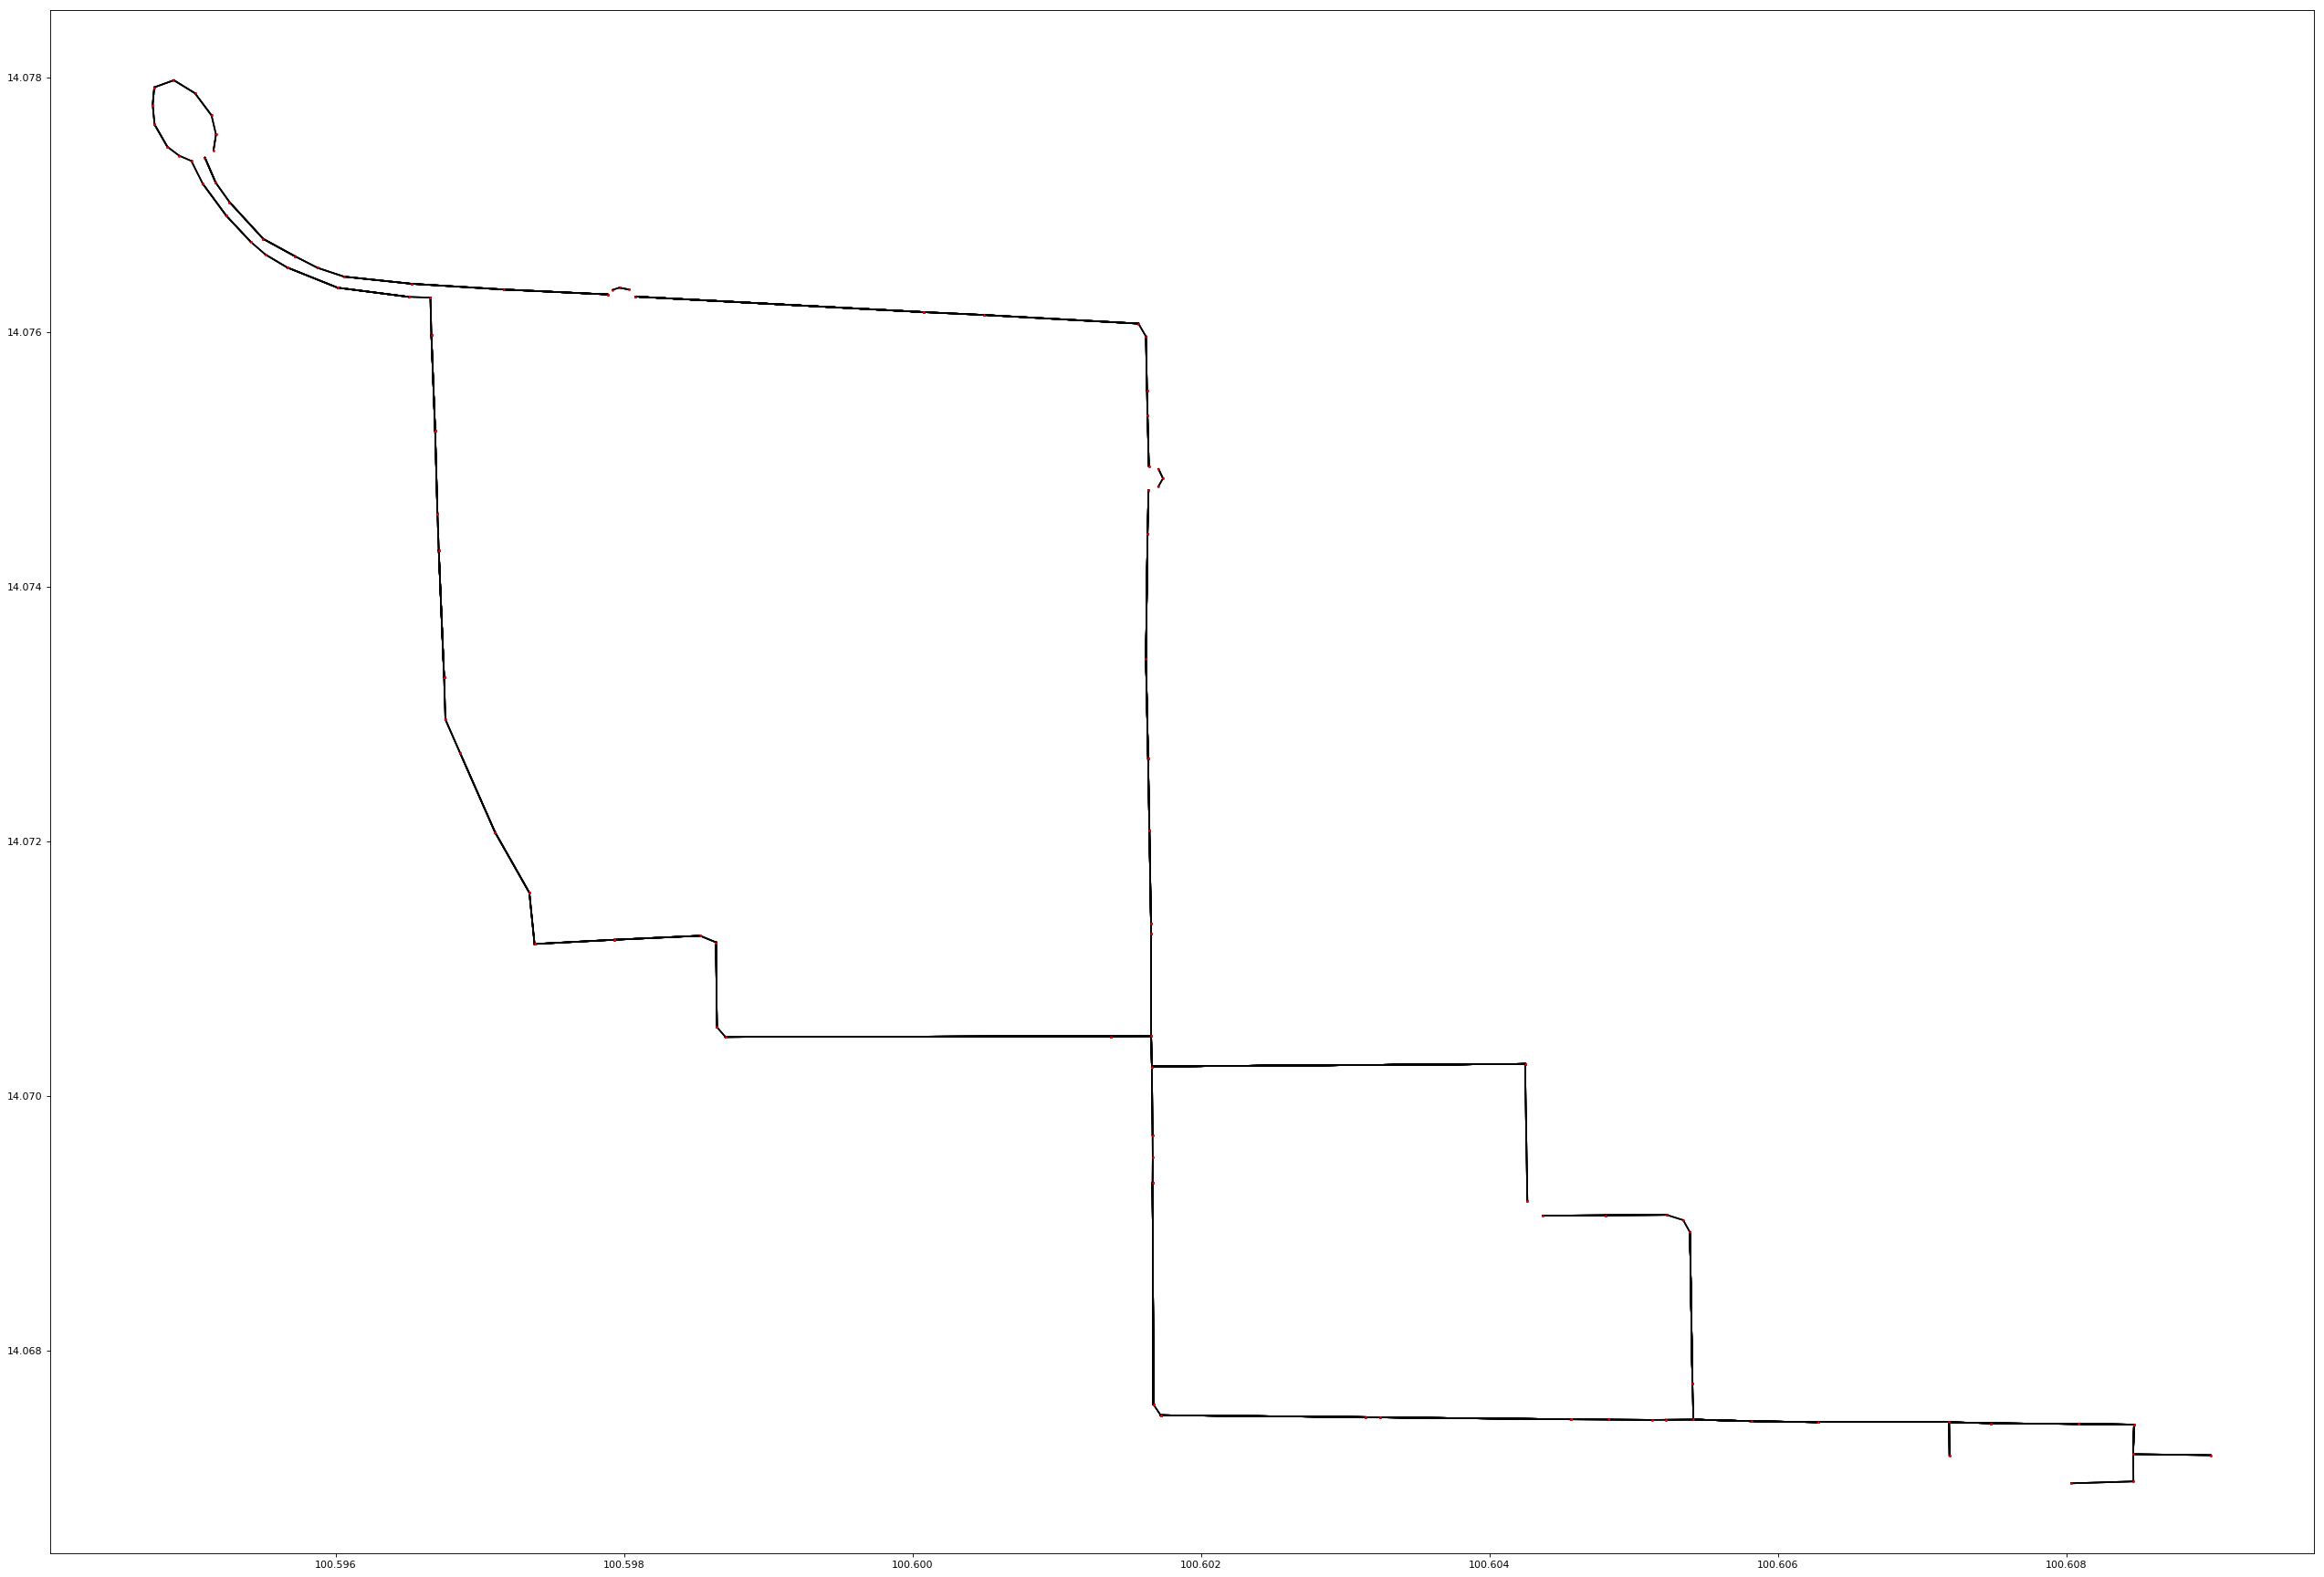

In [229]:
prev = ''
plt.subplots(figsize = (40,28), dpi= 80)
for sid in s_l:
    if sid != prev:
        print(sid)
        G.get_segment_by_id(sid).draw()
        prev = sid
    G.get_segment_by_id(sid).draw()
    

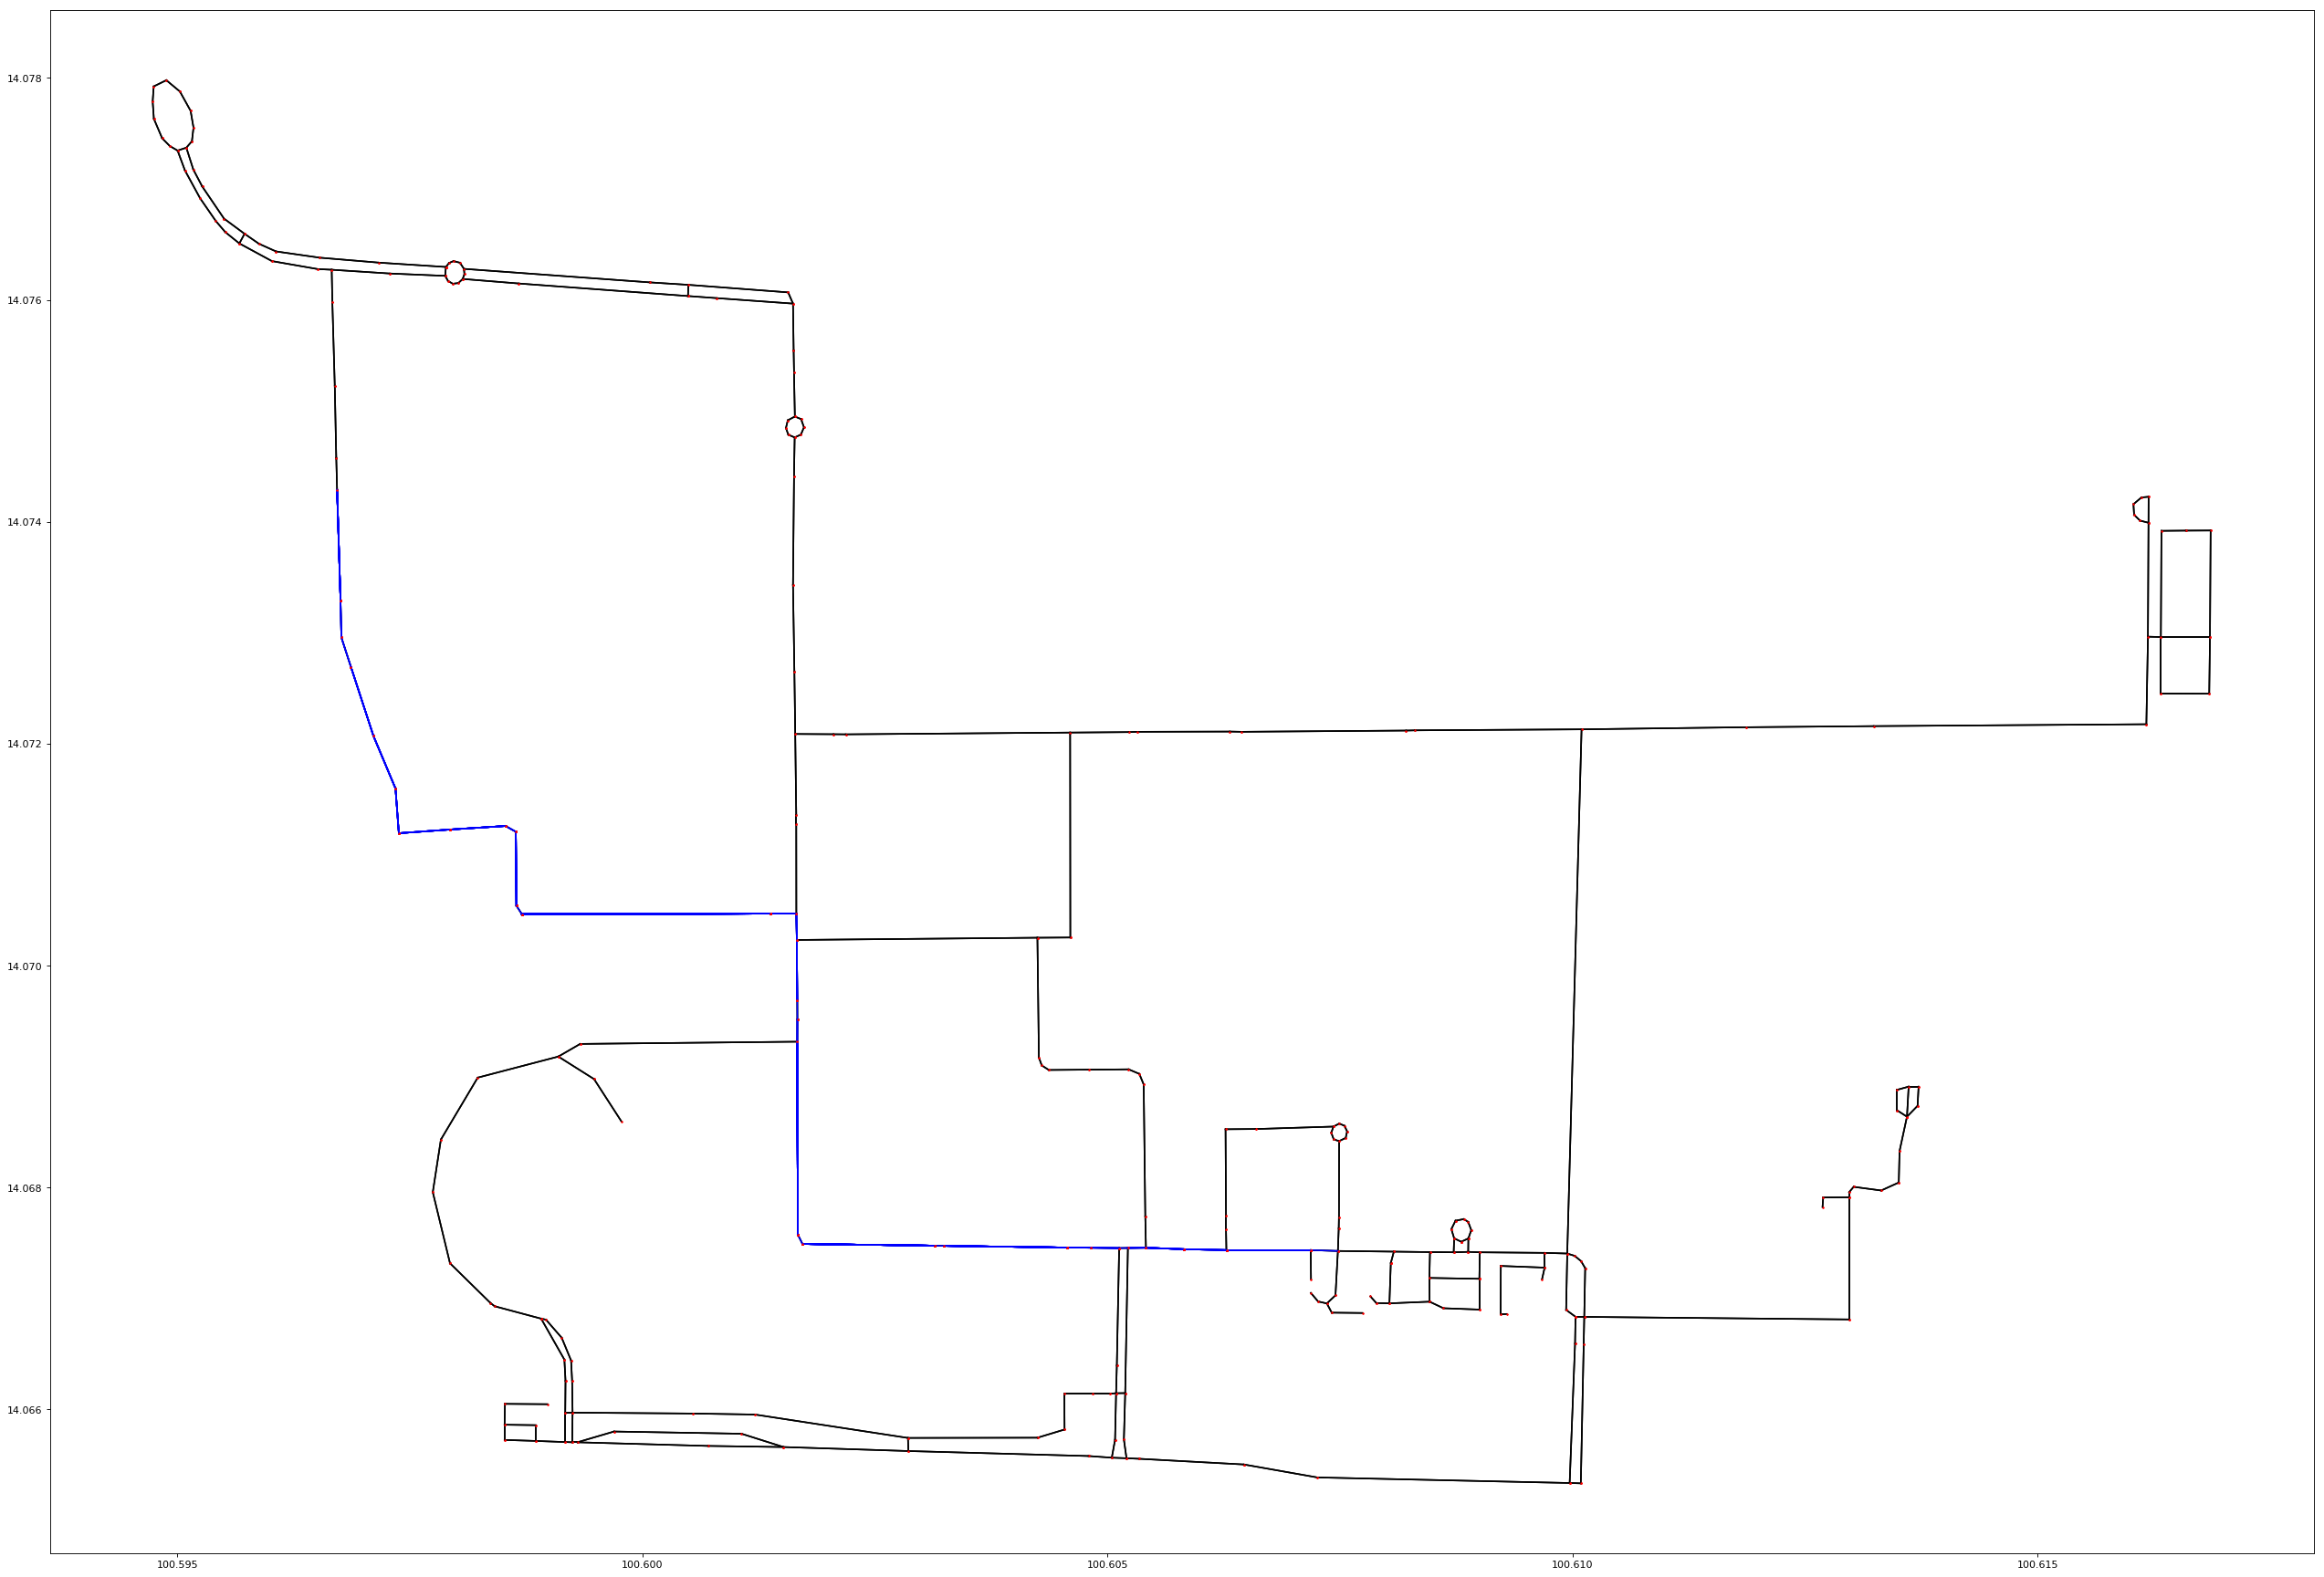

In [216]:
fig, ax = plt.subplots(figsize = (40,28), dpi= 80)
BBox = (100.59466123580931, 100.6096762418747, 14.0657426, 14.077905553749266)
# ax.set_title('Plotting Spatial Data on TU-NGV Map')
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])

for sid in G.segments:
    G.segments[sid].draw()

for sid in s_l[:200]:
    G.get_segment_by_id(sid).draw('b-')

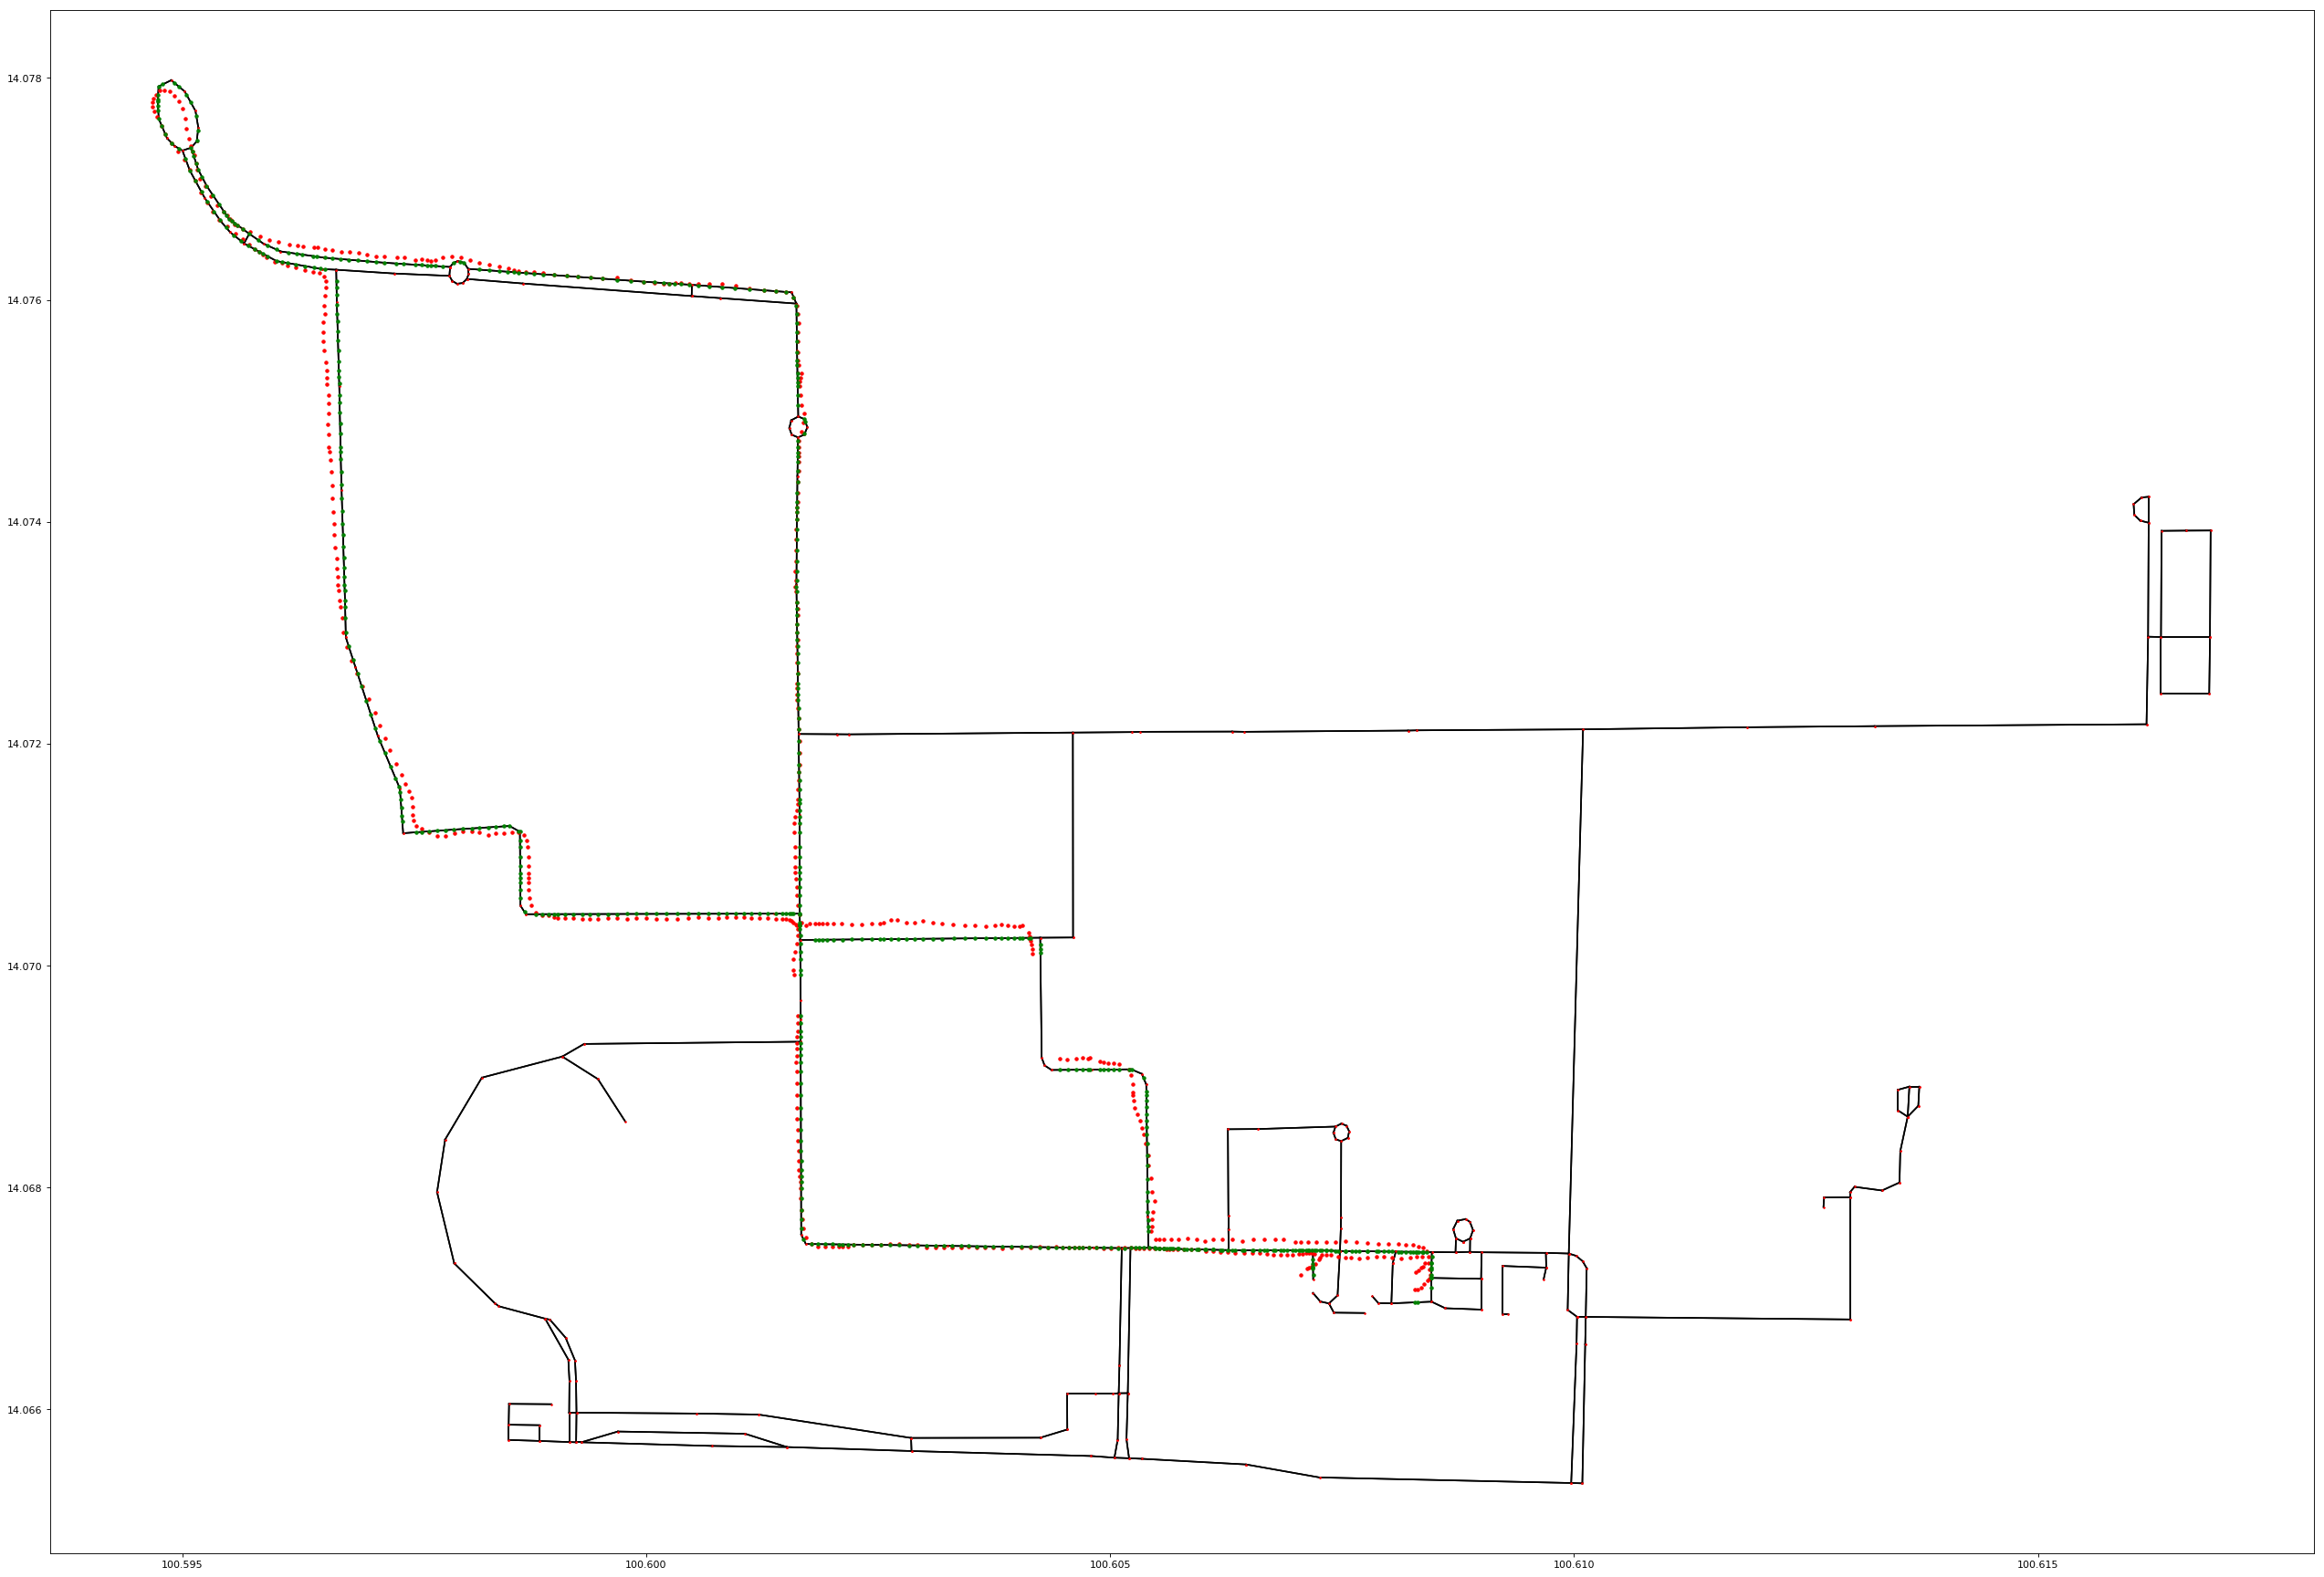

In [217]:

BBox = (100.59466123580931, 100.6096762418747, 14.0657426, 14.077905553749266)
ax.set_title('Plotting Spatial Data on TU-NGV Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

fig, ax = plt.subplots(figsize = (40,28), dpi= 80)
for sid in G.segments:
    G.segments[sid].draw()
# for gid, gps in gps_log.iloc[499:501].iterrows():
# plt.plot(gps['lon'], gps['lat'], "bo", markersize=5)

# tid, segment, dist = c
# segment.ps.draw('go')
# segment.pe.draw('go')
# segment.match(p).draw('bo')
# segment.draw('r')

for match_p, gps_p in gc:
    gps_p.draw('ro', markersize=3)
    match_p.draw('go', markersize=3)
    
# traj = G.get_trajectory_by_id('way/228788194_b')
# traj.ps.draw('bo')
# traj.pe.draw('bo')
# for segment in traj.S:
#     segment.draw('b-')
    

In [ ]:
    coordinates = feature['geometry']['coordinates']
    coordinates = np.array(coordinates).T
    dist = haversine_np(coordinates[0][:-1], coordinates[1][:-1],
                        coordinates[0][1:], coordinates[1][1:])
    dist_arr.append(dist)

In [ ]:

gps = gps_log.loc[235]
c = get_closest_segment(gps.lon, gps.lat)
print(len(c))
p = Point('', gps.lon, gps.lat)
# traj = G.get_trajectory_by_id('way/228788194_b')
traj = c[0]
traj.ps.draw('go')
traj.pe.draw('bo')
p.draw()

s = traj.ps
e = traj.pe
plt.plot([s.lon, e.lon], [s.lat, e.lat])
    
closest_dist(p, s, e)